# Regressão Logística

In [1]:
# normalizar features no pré-processamento
# tratar possibilidade de overflow na função logística
# utilizar loss function 

## Importações

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Leitura de Dados

In [3]:
treinamento = pd.read_csv('diabetes_train.csv')

In [4]:
teste = pd.read_csv('diabetes_test.csv')

## Pré-processamento

In [5]:
class Encoders:
    def __init__(self):
        self.encoders = {}

    def add_encoder(self, feature, encoder):
        self.encoders[feature] = encoder

    def get_encoder(self, feature):
        try:
            return self.encoders[feature]
        except KeyError:
            return None

In [6]:
encoders = Encoders()

In [7]:
def cria_encoder(feature, nome, encoders):
    encoder = LabelEncoder()
    feature_codificada = encoder.fit_transform(feature)
    encoders.add_encoder(nome, encoder)
    return feature_codificada


In [8]:
def verifica_features_categoricas(dados, encoders):
    for i in range(int(dados.size/len(dados)) - 1):
        feature = dados.iloc[:, i]
        if not all(isinstance(instancia, (int, float)) for instancia in (feature.values).tolist()):
            y = encoders.get_encoder(feature.name)
            if y == None:
                dados.loc[:, feature.name] = cria_encoder((feature.values).tolist(), feature.name, encoders)
            else:
                dados.loc[:, feature.name] = y.transform((feature.values).tolist())
    
    return dados

In [9]:
treinamento = verifica_features_categoricas(treinamento, encoders)
teste = verifica_features_categoricas(teste, encoders)

In [10]:
x_treinamento, x_teste = treinamento.iloc[:, :-1].values, teste.iloc[:, :-1].values

In [11]:
y_treinamento, y_teste = treinamento.iloc[:, -1].values, teste.iloc[:, -1].values

## Algoritmo

In [12]:
class LogisticRegression:
    def __init__(self, alpha = 1, l = 1, tolerancia = 0.0001):
        self.taxa_aprendizado = alpha
        self.param_regularizacao = l
        self.tolerancia = tolerancia
        self.qtd_features = None
        self.qtd_instancias = None
        self.parametros = None
        self.max_iteracoes = 1000

    def fit(self, x, y):
        self.qtd_instancias = len(x)
        self.qtd_features = int(x.size/self.qtd_instancias)
        self.parametros = np.ones(self.qtd_features + 1).reshape(-1, 1)

        matriz_design = np.column_stack([np.ones(self.qtd_instancias), x])
        y = np.array(y).reshape(-1, 1)

        erro = 1000

        qtd_iteracoes = 0

        while(erro > self.tolerancia and qtd_iteracoes <= self.max_iteracoes):
            regressao_linear = (np.dot(matriz_design, self.parametros)).astype(np.float64)
            y_previsto = list(map(self.funcao_logistica, regressao_linear))
            y_previsto = np.array(y_previsto).reshape(-1, 1)
            matriz_transposta = matriz_design.T
            vetor_gradiente = np.dot(matriz_transposta, y_previsto - y)

            penalidade_ridge = self.parametros.copy() * self.param_regularizacao
            penalidade_ridge[0] = 0

            novos_parametros = self.parametros - (vetor_gradiente + penalidade_ridge) * (self.taxa_aprendizado/self.qtd_instancias)
            erro = np.sum(abs(self.parametros - novos_parametros))/len(self.parametros)
            self.parametros = novos_parametros
            qtd_iteracoes += 1
        
    def funcao_logistica(self, t):
        return 1/(1 + np.exp(-t))
    
    def prob_logistica(self, p, threshold):
        return 1 if p >= threshold else 0
    
    def predict(self, x, threshold = 0.5):
        self.qtd_instancias = len(x)

        matriz_design = np.column_stack([np.ones(self.qtd_instancias), x])
        regressao_linear = (np.dot(matriz_design, self.parametros)).astype(np.float64)
        y_previsto = list(map(self.funcao_logistica, regressao_linear))

        return list(map(lambda y: self.prob_logistica(y, threshold), y_previsto))
    
    def confusion_matrix(self, previsoes, real):
        matriz_confusao = np.zeros((2, 2))

        for i, k in zip(previsoes, real):
            matriz_confusao[k][i] += 1

        return matriz_confusao
    
    def score(self, y_resultado, y_teste):
        matriz_confusao = self.confusion_matrix(y_resultado, y_teste)

        acuracia = np.sum(np.diagonal(matriz_confusao))/np.sum(matriz_confusao) * 100
        precisao = (matriz_confusao[1][1]/(np.sum(matriz_confusao[:, 1]))) * 100
        revocacao = (matriz_confusao[1][1] / (np.sum(matriz_confusao[1][:]))) * 100
        f1_score = (2/((1/precisao) + 1/(revocacao)))

        print("=" * 10 + " Medições de Desempenho " + "=" * 10)
        print("Matriz de Confusão")
        print(f"{pd.DataFrame(matriz_confusao, columns=['0', '1'])}")
        print(f"\nAcurácia: {acuracia:.2f}%")
        print(f"Precisão: {precisao:.2f}%")
        print(f"Revocação: {revocacao:.2f}%")
        print(f"F1-Score: {f1_score:.2f}%")
        print("=" * 44)
    
    def roc_curve(self, x_teste, y_teste):
        threshold = np.arange(start=0, stop=1, step=0.01)
        predicoes = list((map(lambda t:  self.predict(x_teste, t), threshold)))
        
        taxa_verdadeiros_positivos, taxa_falsos_negativos = [], []

        for i in range(len(predicoes)):
            m = self.confusion_matrix(predicoes[i], y_teste)
            tpr = (m[1][1]/(np.sum(m[1][:])))

            if np.sum(m[0][:]) != 0: fnr = (m[0][1]/(np.sum(m[0][:])))
            else: fnr = 0

            taxa_verdadeiros_positivos.append(tpr)
            taxa_falsos_negativos.append(fnr)

        plt.plot(taxa_falsos_negativos, taxa_verdadeiros_positivos)
        plt.xlabel("Taxa de Falsos Positivos")
        plt.ylabel("Taxa de Verdadeiros Positivos")
        plt.title("Curva ROC")
        plt.show()


In [13]:
regressao_logistica = LogisticRegression()
regressao_logistica.fit(x_treinamento, y_treinamento)
y_resultado = regressao_logistica.predict(x_teste)
regressao_logistica.score(y_resultado, y_teste)

========== Medições de Desempenho ==========
Matriz de Confusão
      0      1
0  74.0    7.0
1   6.0  121.0

Acurácia: 93.75%
Precisão: 94.53%
Revocação: 95.28%
F1-Score: 94.90%


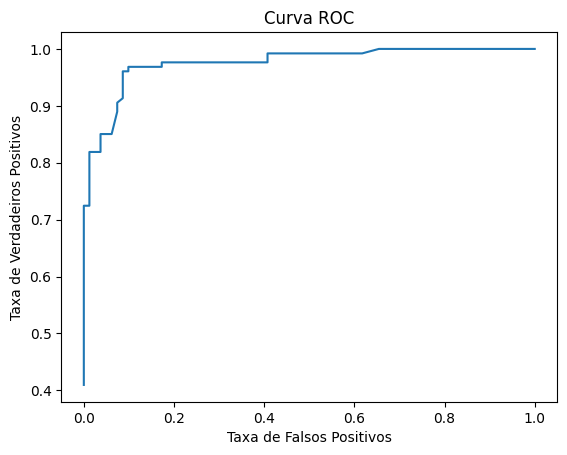

In [14]:
regressao_logistica.roc_curve(x_teste, y_teste)